### Preparation steps

Install iotfunctions with

`pip install git+https://github.com/ibm-watson-iot/functions@development`

This projects contains the code for the Analytics Service pipeline as well as the anomaly functions and should pull in most of this notebook's dependencies.

The plotting library matplotlib is the exception, so you need to run
`pip install matplotlib`


#### Unpacking the data

Data is stored in `ArmstarkPumps_3408_36B1_096.tar.bz2`

Please run `tar xfj ArmstarkPumps_3408_36B1_096.tar.bz2` to unpack it prior to running this notebook. You should find 

```
-rw-rw-r-- 1 markus markus 72361832 Dez 22 17:10 04714B603408.csv
-rw-rw-r-- 1 markus markus 71782702 Dez 22 16:43 04714B6036B1.csv
-rw-rw-r-- 1 markus markus 50373659 Dez 22 16:43 IOT_PUMP_DE_GEN5_202012141519.csv
```

In [1]:
# Real life data

import logging
import threading
import itertools
import math
import datetime
import pandas as pd  
import numpy as np  
import scipy as sp
import json
import ibm_db

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore, DBModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.bif import PythonExpression
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from iotfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore,
                 SaliencybasedGeneralizedAnomalyScoreV2, FFTbasedGeneralizedAnomalyScoreV2, 
                 KMeansAnomalyScoreV2, BayesRidgeRegressor,)
from mmfunctions.anomaly import (FeatureBuilder, GBMForecaster, KDEAnomalyScore, VIAnomalyScore)
#from poc.functions import State_Timer
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [2]:
# set up a db object with a FileModelStore to support scaling
with open('credentials_as_beta3.json', encoding='utf-8') as F:
    credentials = json.loads(F.read())
db_schema=None
#fm = FileModelStore()
#db = Database(credentials=credentials, model_store=fm)
# 11390 is the entity type id of shadow_pump_de_gen5
db=Database(credentials=credentials, entity_type_id=11930)


# 11390 is the entity type id of shadow_pump_de_gen5
if db.model_store is None:
     db.model_store = DBModelStore('beta-3', 11390, 'bluadmin', db.native_connection, db.db_type)

print (db)

In [3]:
db.model_store = FileModelStore()
db.native_connection

2021-06-14T18:56:42.277 INFO iotfunctions.dbtables.__init__ Init FileModelStore with path: 


In [4]:
def load_data(filename):
    # load data
    df_input = pd.read_csv(filename, parse_dates=['RCV_TIMESTAMP_UTC'], comment='#')
    #df_input = df_input.asfreq('H')
    df_input = df_input.sort_values(by='RCV_TIMESTAMP_UTC').\
                    rename(columns={'RCV_TIMESTAMP_UTC':'timestamp', 'DEVICEID': 'entity'}).\
                    drop(columns=['DEVICETYPE','ID','FORMAT','UPDATED_UTC','LOGICALINTERFACE_ID','PUMP_MODE',\
                                  'DEVICE_ID','FIRMWARE_VER','PTS_COUNT','SERIAL_NUMBER', 'HARDWARE_VER',\
                                  'TAG_NUMBER','PWR','HW_VER','DQ','FW_VER','PTS','PERF_OPTION']).\
                    drop(columns=['VIBRATION_N_XAXIS','VIBRATION_N_YAXIS','VIBRATION_N_ZAXIS','REATED_POWER',\
                                  'RATED_SPEED','RATED_CURRENT','RMSN_X','RMSN_Y','RMSN_Z','RUN_QTY',\
                                  'DESIGN_HEAD','DESIGN_FLOW','RMS_X_AVG'])

    df_input = df_input[df_input['VERSION'] != 0].drop(columns=['VERSION'])
    
    
    return df_input


    
def prep_data(df_input):
    entity = df_input['entity'].values[0]
    
    list_ac_vx = []
    cnt = 0
    for idx,row in df_input[['timestamp','VIBRATIONS_XAXIS','VIBRATIONS_YAXIS','VIBRATIONS_ZAXIS',
                             'ACCEL_POWER','ACCEL_SPEED']].iterrows():
        if isinstance(row['timestamp'], str):
            ts = datetime.datetime.strptime(row['timestamp'], '%Y-%m-%d-%H.%M.%S.%f')
        else:
            ts = row['timestamp']
            
        rvibxs = row['VIBRATIONS_XAXIS']
        rvibys = row['VIBRATIONS_YAXIS']
        rvibzs = row['VIBRATIONS_ZAXIS']
        racc = row['ACCEL_POWER']
        rspd = row['ACCEL_SPEED']

        if isinstance(racc, str):
            racc = eval(racc)
        if isinstance(rspd, str):
            rspd = eval(rspd)
            
        if isinstance(rvibxs, str):
            list_ac = []
           
            for ac in racc:
                #print(ac)
                list_ac.append(eval(ac))
                list_ac.append(eval(ac))
                list_ac.append(eval(ac))
                #print (list_ac)
            
            list_as = []
            for as_ in rspd:
                list_as.append(eval(as_))
                list_as.append(eval(as_))
                list_as.append(eval(as_))
            
            list_vx = []
            for vx in eval(rvibxs):
                list_vx.append(vx)
                #print (list_vx)
            
            list_vy = []
            for vy in eval(rvibys):
                list_vy.append(vy)
            
            list_vz = []
            for vz in eval(rvibzs):
                list_vz.append(vz)

            #print(list_ac, list_vx)
            cnt2 = 0
            for p in zip(list_ac, list_as, list_vx, list_vy, list_vz):
                #print(ts + datetime.timedelta(seconds = cnt2 * 10), p[0],p[1])
                list_ac_vx.append([ts + datetime.timedelta(seconds = cnt2 * 10), p[0],p[1],p[2],p[3],p[4]])
                cnt2 += 1
        cnt += 1

    df_clean = pd.DataFrame(list_ac_vx, columns=['timestamp','power','speed','rms_x', 'rms_y', 'rms_z'])
    df_clean['entity'] = entity
    
    return df_clean.set_index(['entity','timestamp'])
    

In [5]:
#df_clean = prep_data(load_data('./IOT_PUMP_DE_GEN5_202012141519.csv'))

#df_clean.head(2)

In [6]:
filename = "./IOT_SHADOW_PUMP_DE_GEN5_202102051132.csv"
dff = pd.read_csv(filename, parse_dates=['EVT_TIMESTAMP'], comment='#')
dff.columns = dff.columns.str.lower() 
df_clean = dff.drop(columns=['devicetype','logicalinterface_id','eventtype','format',
                             'rcv_timestamp_utc','updated_utc']).set_index(['deviceid','evt_timestamp'])

In [7]:
df_clean

rms_x     rms_z     rms_y   power  \
deviceid     evt_timestamp                                                      
04714B601096 2020-07-19-11.38.48.552000       NaN       NaN       NaN  1.7290   
             2020-07-19-11.39.08.552000       NaN       NaN       NaN  1.7290   
             2020-07-19-11.39.28.701000  0.095508  0.062686  0.957628  1.7258   
             2020-07-19-11.39.48.701000  0.089758  0.064799  0.956392  1.7258   
             2020-07-19-11.40.08.701000  0.093306  0.064766  0.957083  1.7258   
...                                           ...       ...       ...     ...   
             2021-01-11-14.16.56.144000       NaN       NaN       NaN  2.4482   
             2021-01-11-14.17.16.144000       NaN       NaN       NaN  2.4482   
             2021-01-11-14.17.36.144000       NaN       NaN       NaN  2.4488   
             2021-01-11-14.17.56.144000       NaN       NaN       NaN  2.4488   
             2021-01-11-14.18.16.144000       NaN       NaN       NaN  2.4488   

                                          speed  
deviceid     evt_timestamp                       
04714B601096 2020-07-19-11.38.48.552000  1059.0  
             2020-07-19-11.39.08.552000  1059.0  
             2020-07-19-11.39.28.701000  1059.0  
             2020-07-19-11.39.48.701000  1059.0  
             2020-07-19-11.40.08.701000  1059.0  
...                                         ...  
             2021-01-11-14.16.56.144000  1105.0  
             2021-01-11-14.17.16.144000  1105.0  
             2021-01-11-14.17.36.144000  1104.0  
             2021-01-11-14.17.56.144000  1104.0  
             2021-01-11-14.18.16.144000  1104.0  

[533940 rows x 5 columns]

In [8]:
df_clean.index.levels[0].values[0]


'04714B601096'

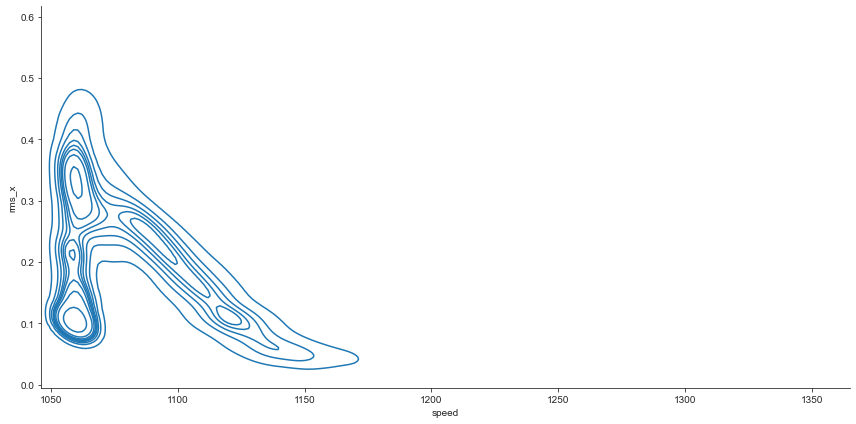

In [16]:
#plt.figure(figsize=(20, 6))

df_display = df_clean[df_clean['speed'] > 1000]

sns.set_style('ticks')
#fig, ax = plt.subplots(1,1,figsize=(20,8))
gx = sns.displot(df_display[['speed','rms_x']], x='speed', y='rms_x', kind="kde", 
                 rug=False, height=6, aspect=2)
    
gx.set_titles('KDE for' + df_clean.index.levels[0].values[0])

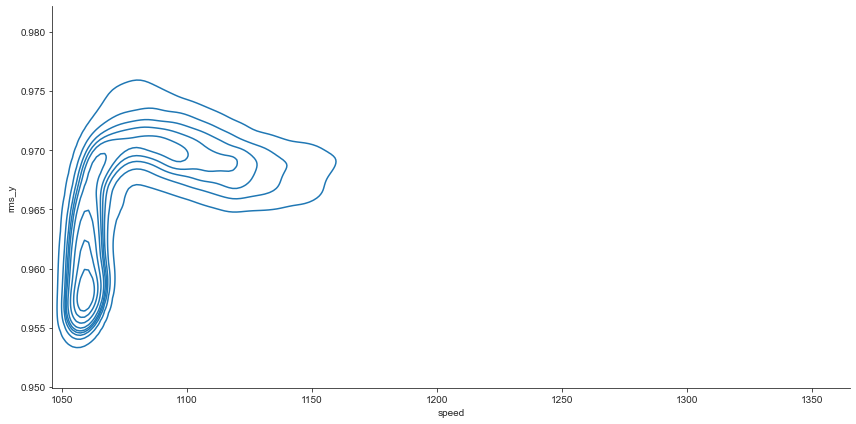

In [17]:
#plt.figure(figsize=(16, 6))
sns.set_style('ticks')
#fig, ax = plt.subplots(1,1,figsize=(20,8))
gy = sns.displot(df_display[['speed','rms_y']], x='speed', y='rms_y', kind="kde", 
                 rug=False, height=6, aspect=2)
gy.set_titles('KDE for' + df_clean.index.levels[0].values[0])

In [9]:
# prepare
delete_model = True
df_i = df_clean.dropna()
#df_i['speed'] /= 10

2021-06-14T18:56:52.790 INFO numexpr.utils._init_num_threads Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-06-14T18:56:52.792 INFO numexpr.utils._init_num_threads NumExpr defaulting to 8 threads.


In [15]:
%%time
print('Train and evaluate model for ' + df_i.index.levels[0].values[0])
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsi = VIAnomalyScore(['speed'], ['rms_x'])
#spsi.epochs = 1  # only for testing model storage
spsi.epochs = 100

spsi.auto_train = True
spsi.delete_model = delete_model
et = spsi._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
et.name = 'IOT_SHADOW_PUMP_DE_GEN5'



spsi._entity_type = et
df_i = spsi.execute(df=df_i)

EngineLogging.configure_console_logging(logging.INFO)
df_i.describe()

Train and evaluate model for 04714B601096
2021-06-14T18:59:18.884 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2021-06-14T18:59:18.886 DEBUG root.__init__ __init__VIAnomalyScore
2021-06-14T18:59:18.888 DEBUG root.__init__ __init__ done with parameters: speed.rms_x
2021-06-14T18:59:18.891 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.3.1
2021-06-14T18:59:18.893 DEBUG iotfunctions.util.__init__ Starting trace
2021-06-14T18:59:18.894 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_VIAnomalyScore_20210614165918
2021-06-14T18:59:18.896 DEBUG iotfunctions.util.__init__ auto_save None
2021-06-14T18:59:18.897 DEBUG iotfunctions.util.categorize_args categorizing arguments
2021-06-14T18:59:18.898 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2021-06-14T18:59:18

,rms_x,rms_z,rms_y,power,speed,predicted_rms_x,pred_dev_rms_x
count,177980.000000,177980.000000,177980.000000,177980.000000,177980.000000,177980.000000,177980.000000
mean,0.201499,0.087049,0.964827,2.052877,1079.609838,0.201207,0.206275
std,0.101279,0.028381,0.005473,0.435038,30.031477,0.050066,0.098181
min,0.018446,0.027219,0.952113,0.115600,212.000000,-0.344524,-0.046552
25%,0.108721,0.065397,0.959472,1.740200,1059.000000,0.211667,0.145360
50%,0.189055,0.078209,0.965996,1.795200,1062.000000,0.213920,0.266928
75%,0.278364,0.100557,0.969530,2.325800,1096.000000,0.220591,0.272250
max,0.576303,0.244273,0.979979,6.122200,1353.000000,0.273488,3.613402


In [16]:
%%time
print('Train and evaluate model for ' + df_i.index.levels[0].values[0])
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsiy = VIAnomalyScore(['speed'], ['rms_y'])
#spsiy.epochs = 1  # only for testing model storage
spsiy.epochs = 100

spsiy.auto_train = True
spsiy.delete_model = delete_model
ety = spsiy._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
ety.name = 'IOT_SHADOW_PUMP_DE_GEN5'

spsiy._entity_type = ety
df_i = spsiy.execute(df=df_i)

EngineLogging.configure_console_logging(logging.INFO)
df_i.describe()

Train and evaluate model for 04714B601096
2021-06-14T19:01:35.645 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2021-06-14T19:01:35.646 DEBUG root.__init__ __init__VIAnomalyScore
2021-06-14T19:01:35.646 DEBUG root.__init__ __init__ done with parameters: speed.rms_y
2021-06-14T19:01:35.648 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.3.1
2021-06-14T19:01:35.648 DEBUG iotfunctions.util.__init__ Starting trace
2021-06-14T19:01:35.649 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_VIAnomalyScore_20210614170135
2021-06-14T19:01:35.649 DEBUG iotfunctions.util.__init__ auto_save None
2021-06-14T19:01:35.649 DEBUG iotfunctions.util.categorize_args categorizing arguments
2021-06-14T19:01:35.650 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2021-06-14T19:01:35

,rms_x,rms_z,rms_y,power,speed,predicted_rms_x,pred_dev_rms_x,predicted_rms_y,pred_dev_rms_y
count,177980.000000,177980.000000,177980.000000,177980.000000,177980.000000,177980.000000,177980.000000,177980.000000,177980.000000
mean,0.201499,0.087049,0.964827,2.052877,1079.609838,0.201207,0.206275,0.965113,0.020710
std,0.101279,0.028381,0.005473,0.435038,30.031477,0.050066,0.098181,0.004754,0.007491
min,0.018446,0.027219,0.952113,0.115600,212.000000,-0.344524,-0.046552,0.682788,0.018002
25%,0.108721,0.065397,0.959472,1.740200,1059.000000,0.211667,0.145360,0.960760,0.019356
50%,0.189055,0.078209,0.965996,1.795200,1062.000000,0.213920,0.266928,0.963246,0.019845
75%,0.278364,0.100557,0.969530,2.325800,1096.000000,0.220591,0.272250,0.969370,0.021271
max,0.576303,0.244273,0.979979,6.122200,1353.000000,0.273488,3.613402,0.979067,1.278452


In [17]:
%%time
print('Train and evaluate model for ' + df_i.index.levels[0].values[0])
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsiz = VIAnomalyScore(['speed'], ['rms_z'])
#spsiz.epochs = 1  # only for testing model storage
spsiz.epochs = 100 #300

spsiz.auto_train = True
spsiz.delete_model = delete_model
etz = spsiz._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
etz.name = 'IOT_SHADOW_PUMP_DE_GEN5'

spsiz._entity_type = etz
df_i = spsiz.execute(df=df_i)

EngineLogging.configure_console_logging(logging.INFO)
df_i.describe()

Train and evaluate model for 04714B601096
2021-06-14T19:03:59.323 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2021-06-14T19:03:59.324 DEBUG root.__init__ __init__VIAnomalyScore
2021-06-14T19:03:59.324 DEBUG root.__init__ __init__ done with parameters: speed.rms_z
2021-06-14T19:03:59.330 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.3.1
2021-06-14T19:03:59.331 DEBUG iotfunctions.util.__init__ Starting trace
2021-06-14T19:03:59.331 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_VIAnomalyScore_20210614170359
2021-06-14T19:03:59.332 DEBUG iotfunctions.util.__init__ auto_save None
2021-06-14T19:03:59.334 DEBUG iotfunctions.util.categorize_args categorizing arguments
2021-06-14T19:03:59.334 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2021-06-14T19:03:59

,rms_x,rms_z,rms_y,power,speed,predicted_rms_x,pred_dev_rms_x,predicted_rms_y,pred_dev_rms_y,predicted_rms_z,pred_dev_rms_z
count,177980.000000,177980.000000,177980.000000,177980.000000,177980.000000,177980.000000,177980.000000,177980.000000,177980.000000,177980.000000,177980.000000
mean,0.201499,0.087049,0.964827,2.052877,1079.609838,0.201207,0.206275,0.965113,0.020710,0.155766,0.270742
std,0.101279,0.028381,0.005473,0.435038,30.031477,0.050066,0.098181,0.004754,0.007491,0.039553,0.129460
min,0.018446,0.027219,0.952113,0.115600,212.000000,-0.344524,-0.046552,0.682788,0.018002,0.070127,-0.013696
25%,0.108721,0.065397,0.959472,1.740200,1059.000000,0.211667,0.145360,0.960760,0.019356,0.131895,0.278962
50%,0.189055,0.078209,0.965996,1.795200,1062.000000,0.213920,0.266928,0.963246,0.019845,0.180334,0.294310
75%,0.278364,0.100557,0.969530,2.325800,1096.000000,0.220591,0.272250,0.969370,0.021271,0.186399,0.297941
max,0.576303,0.244273,0.979979,6.122200,1353.000000,0.273488,3.613402,0.979067,1.278452,1.624433,22.569778


In [18]:
et.name

'IOT_SHADOW_PUMP_DE_GEN5'

In [19]:
df_i.columns

Index(['rms_x', 'rms_z', 'rms_y', 'power', 'speed', 'predicted_rms_x',
       'pred_dev_rms_x', 'predicted_rms_y', 'pred_dev_rms_y',
       'predicted_rms_z', 'pred_dev_rms_z'],
      dtype='object')

In [20]:
df_i.describe()

,rms_x,rms_z,rms_y,power,speed,predicted_rms_x,pred_dev_rms_x,predicted_rms_y,pred_dev_rms_y,predicted_rms_z,pred_dev_rms_z
count,177980.000000,177980.000000,177980.000000,177980.000000,177980.000000,177980.000000,177980.000000,177980.000000,177980.000000,177980.000000,177980.000000
mean,0.201499,0.087049,0.964827,2.052877,1079.609838,0.201207,0.206275,0.965113,0.020710,0.155766,0.270742
std,0.101279,0.028381,0.005473,0.435038,30.031477,0.050066,0.098181,0.004754,0.007491,0.039553,0.129460
min,0.018446,0.027219,0.952113,0.115600,212.000000,-0.344524,-0.046552,0.682788,0.018002,0.070127,-0.013696
25%,0.108721,0.065397,0.959472,1.740200,1059.000000,0.211667,0.145360,0.960760,0.019356,0.131895,0.278962
50%,0.189055,0.078209,0.965996,1.795200,1062.000000,0.213920,0.266928,0.963246,0.019845,0.180334,0.294310
75%,0.278364,0.100557,0.969530,2.325800,1096.000000,0.220591,0.272250,0.969370,0.021271,0.186399,0.297941
max,0.576303,0.244273,0.979979,6.122200,1353.000000,0.273488,3.613402,0.979067,1.278452,1.624433,22.569778


In [21]:
#df_1[['AnomalyZ']].dropna()

In [22]:
# no multilevel index for plotting
df_1 = df_i.loc[df_i.index.levels[0].values[0]].copy()

# remove speed < 400
df_1[df_1['speed'] < 400] = np.nan

Text(0.5, 1.0, 'pump 04714B601096')

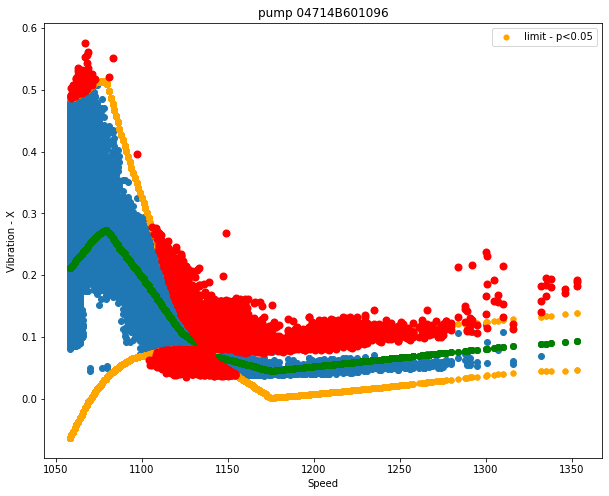

In [23]:
rmsstr = 'rms_x'
predstr = 'predicted_rms_x'
preddstr = 'pred_dev_rms_x'
anostr = 'AnomalyX'

# X-coordinate
arr1 = np.where(df_1[rmsstr] > df_1[predstr] + df_1[preddstr], df_1[rmsstr], 0) + \
       np.where(df_1[rmsstr] < df_1[predstr] - df_1[preddstr], df_1[rmsstr], 0)
arr1[arr1 == 0] = np.nan
df_1[anostr] = arr1

fig, ax = plt.subplots(1, 1, figsize=(10, 8), squeeze=False)

ax[0,0].scatter(df_1['speed'], df_1[rmsstr])
ax[0,0].scatter(df_1['speed'], df_1[predstr], color='green')
ax[0,0].scatter(df_1['speed'], df_1[predstr] - df_1[preddstr], color='orange', lw=0.1, label='limit - p<0.05')
ax[0,0].scatter(df_1['speed'], df_1[predstr] + df_1[preddstr], color='orange', lw=0.1)
ax[0,0].scatter(df_1['speed'], df_1[anostr], color='red', lw=2)
ax[0,0].set_xlabel('Speed')
ax[0,0].set_ylabel('Vibration - X')
ax[0,0].legend()
ax[0,0].set_title('pump ' + df_i.index.levels[0].values[0])

Text(0.5, 1.0, 'pump 04714B601096')

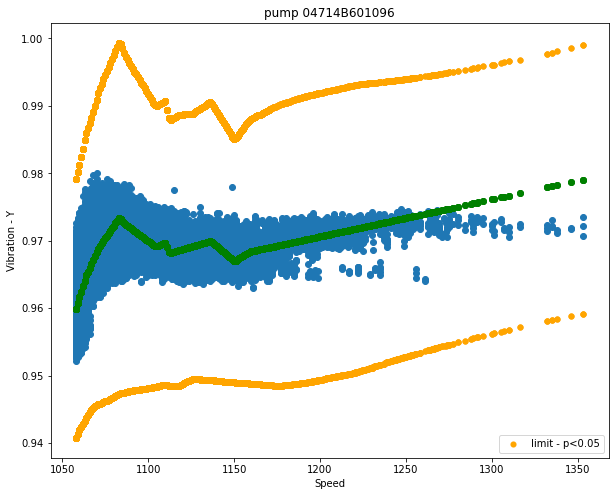

In [24]:
rmsstr = 'rms_y'
predstr = 'predicted_rms_y'
preddstr = 'pred_dev_rms_y'
anostr = 'AnomalyY'

# Y-coordinate
arr1 = np.where(df_1[rmsstr] > df_1[predstr] + df_1[preddstr], df_1[rmsstr], 0) + \
       np.where(df_1[rmsstr] < df_1[predstr] - df_1[preddstr], df_1[rmsstr], 0)
arr1[arr1 == 0] = np.nan
df_1[anostr] = arr1

fig, ax = plt.subplots(1, 1, figsize=(10, 8), squeeze=False)

ax[0,0].scatter(df_1['speed'], df_1[rmsstr])
ax[0,0].scatter(df_1['speed'], df_1[predstr], color='green')
ax[0,0].scatter(df_1['speed'], df_1[predstr] - df_1[preddstr], color='orange', lw=0.1, label='limit - p<0.05')
ax[0,0].scatter(df_1['speed'], df_1[predstr] + df_1[preddstr], color='orange', lw=0.1)
ax[0,0].scatter(df_1['speed'], df_1[anostr], color='red', lw=2)
ax[0,0].set_xlabel('Speed')
ax[0,0].set_ylabel('Vibration - Y')
ax[0,0].legend()
ax[0,0].set_title('pump ' + df_i.index.levels[0].values[0])

Text(0.5, 1.0, 'pump 04714B601096')

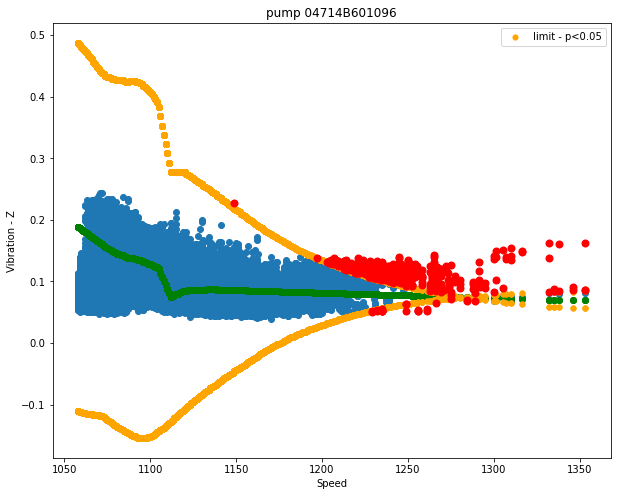

In [25]:
rmsstr = 'rms_z'
predstr = 'predicted_rms_z'
preddstr = 'pred_dev_rms_z'
anostr = 'AnomalyZ'

# Z-coordinate
arr1 = np.where(df_1[rmsstr] > df_1[predstr] + df_1[preddstr], df_1[rmsstr], 0) + \
       np.where(df_1[rmsstr] < df_1[predstr] - df_1[preddstr], df_1[rmsstr], 0)
arr1[arr1 == 0] = np.nan
df_1[anostr] = arr1

fig, ax = plt.subplots(1, 1, figsize=(10, 8), squeeze=False)

ax[0,0].scatter(df_1['speed'], df_1[rmsstr])
ax[0,0].scatter(df_1['speed'], df_1[predstr], color='green')
ax[0,0].scatter(df_1['speed'], df_1[predstr] - df_1[preddstr], color='orange', lw=0.1, label='limit - p<0.05')
ax[0,0].scatter(df_1['speed'], df_1[predstr] + df_1[preddstr], color='orange', lw=0.1)
ax[0,0].scatter(df_1['speed'], df_1[anostr], color='red', lw=2)
ax[0,0].set_xlabel('Speed')
ax[0,0].set_ylabel('Vibration - Z')
ax[0,0].legend()
ax[0,0].set_title('pump ' + df_i.index.levels[0].values[0])

In [ ]:
#df_1 = df_i.loc[df_i.index.levels[0].values[0]].copy()

fig, ax = plt.subplots(2, 2, figsize=(20, 6), squeeze=False)

ax[0,0].scatter(df_1['speed'], df_1['rms_x'])
ax[0,0].scatter(df_1['speed'], df_1['predicted_rms_x'], color='green')
ax[0,0].scatter(df_1['speed'], df_1['predicted_rms_x'] - df_1['pred_dev_rms_x'], color='orange', lw=0.1, label='limit - p<0.05')
ax[0,0].scatter(df_1['speed'], df_1['predicted_rms_x'] + df_1['pred_dev_rms_x'], color='orange', lw=0.1)
ax[0,0].scatter(df_1['speed'], df_1['AnomalyX'], color='red', lw=0.5)
ax[0,0].set_xlabel('Speed')
ax[0,0].set_ylabel('Vibration - X')
ax[0,0].legend()
ax[0,0].set_title('pump ' + df_i.index.levels[0].values[0])


ax[0,1].scatter(df_1['speed'], df_1['rms_y'])
ax[0,1].scatter(df_1['speed'], df_1['predicted_rms_y'], color='green')
ax[0,1].scatter(df_1['speed'], df_1['predicted_rms_y'] - df_1['pred_dev_rms_y'], color='orange', lw=0.1, label='limit - p<0.05')
ax[0,1].scatter(df_1['speed'], df_1['predicted_rms_y'] + df_1['pred_dev_rms_y'], color='orange', lw=0.1)
ax[0,1].scatter(df_1['speed'], df_1['AnomalyY'], color='red', lw=0.5)
ax[0,1].set_xlabel('Speed')
ax[0,1].set_ylabel('Vibration - Y')
ax[0,1].legend()
ax[0,1].set_title('pump ' + df_i.index.levels[0].values[0])

ax[1,0].scatter(df_1['speed'], df_1['rms_z'])
ax[1,0].scatter(df_1['speed'], df_1['predicted_rms_z'], color='green')
ax[1,0].scatter(df_1['speed'], df_1['predicted_rms_z'] - df_1['pred_dev_rms_z'], color='orange', lw=0.1, label='limit - p<0.05')
ax[1,0].scatter(df_1['speed'], df_1['predicted_rms_z'] + df_1['pred_dev_rms_z'], color='orange', lw=0.1)
ax[1,0].scatter(df_1['speed'], df_1['AnomalyZ'], color='red', lw=0.5)
ax[1,0].set_xlabel('Speed')
ax[1,0].set_ylabel('Vibration - Z')
ax[1,0].legend()
ax[1,0].set_title('pump ' + df_i.index.levels[0].values[0])


ax[1,1].scatter(df_1['speed'], df_1['rms_y'])
ax[1,1].set_xlabel('Speed')
ax[1,1].set_ylabel('Vibration - Y')
ax[1,1].legend()
ax[1,1].set_title('pump ' + df_i.index.levels[0].values[0] + ' - plain scatterplot')

#plt.fill_between(df_1['Ap'], - df_1['pred_dev_Vx'], df_1['pred_dev_Vx'], alpha=0.2)

In [22]:
'''
df_1i = df_1[24000:28000]
cnt = 0
fig, ax = plt.subplots(1, 1, figsize=(15, 6), squeeze=False)
ax[cnt,0].scatter(df_1i.index,df_1i['rms_x'], lw=0.4, color='green', label='vibration')
ax[cnt,0].scatter(df_1i.index, df_1i['AnomalyX'], lw=0.4, color='red', zorder=10, label='excessive vibration')
ax[cnt,0].legend()
ax[cnt,0].set_title('pump (X)' + df_i.index.levels[0].values[0])
ax[cnt,0].tick_params(axis = "x", which = "both", bottom = False, top = False)
ax[cnt,0].set_xticklabels([])
'''

'\ndf_1i = df_1[24000:28000]\ncnt = 0\nfig, ax = plt.subplots(1, 1, figsize=(15, 6), squeeze=False)\nax[cnt,0].scatter(df_1i.index,df_1i[\'rms_x\'], lw=0.4, color=\'green\', label=\'vibration\')\nax[cnt,0].scatter(df_1i.index, df_1i[\'AnomalyX\'], lw=0.4, color=\'red\', zorder=10, label=\'excessive vibration\')\nax[cnt,0].legend()\nax[cnt,0].set_title(\'pump (X)\' + df_i.index.levels[0].values[0])\nax[cnt,0].tick_params(axis = "x", which = "both", bottom = False, top = False)\nax[cnt,0].set_xticklabels([])\n'

In [23]:
'''
df_1i = df_1[24000:28000]
cnt = 0
fig, ax = plt.subplots(1, 1, figsize=(15, 6), squeeze=False)
ax[cnt,0].scatter(df_1i.index,df_1i['rms_y'], lw=0.4, color='green', label='vibration')
ax[cnt,0].scatter(df_1i.index, df_1i['AnomalyY'], lw=0.4, color='red', zorder=10, label='excessive vibration')
ax[cnt,0].legend()
ax[cnt,0].set_title('pump (Y)' + df_i.index.levels[0].values[0])
ax[cnt,0].tick_params(axis = "x", which = "both", bottom = False, top = False)
ax[cnt,0].set_xticklabels([])
'''

'\ndf_1i = df_1[24000:28000]\ncnt = 0\nfig, ax = plt.subplots(1, 1, figsize=(15, 6), squeeze=False)\nax[cnt,0].scatter(df_1i.index,df_1i[\'rms_y\'], lw=0.4, color=\'green\', label=\'vibration\')\nax[cnt,0].scatter(df_1i.index, df_1i[\'AnomalyY\'], lw=0.4, color=\'red\', zorder=10, label=\'excessive vibration\')\nax[cnt,0].legend()\nax[cnt,0].set_title(\'pump (Y)\' + df_i.index.levels[0].values[0])\nax[cnt,0].tick_params(axis = "x", which = "both", bottom = False, top = False)\nax[cnt,0].set_xticklabels([])\n'

In [24]:
# OOM for ~170000 data points
'''
df_1i = df_1[0:4000]
fig, ax = plt.subplots(4, 1, figsize=(15, 12), squeeze=False)

cnt = 0
ax[0,0].scatter(df_1i.index,df_1i['speed'], lw=0.4, color='orange', zorder=5, label='speed')
cnt += 1
ax[cnt,0].scatter(df_1i.index,df_1i['rms_x'], lw=0.4, color='green', label='vibration')
ax[cnt,0].scatter(df_1i.index, df_1i['AnomalyX'], lw=0.4, color='red', zorder=10, label='excessive vibration')
ax[cnt,0].legend()
ax[cnt,0].set_title('pump (X)' + df_i.index.levels[0].values[0])
cnt += 1
ax[cnt,0].scatter(df_1i.index,df_1i['rms_y'], lw=0.4, color='green', label='vibration')
ax[cnt,0].scatter(df_1i.index, df_1i['AnomalyY'], lw=0.4, color='red', zorder=10, label='excessive vibration')
ax[cnt,0].legend()
ax[cnt,0].set_title('pump (Y)' + df_i.index.levels[0].values[0])
cnt += 1
ax[cnt,0].scatter(df_1i.index,df_1i['rms_z'], lw=0.4, color='green', label='vibration')
ax[cnt,0].scatter(df_1i.index, df_1i['AnomalyZ'], lw=0.4, color='red', zorder=10, label='excessive vibration')
ax[cnt,0].legend()
ax[cnt,0].set_title('pump (Z)' + df_i.index.levels[0].values[0])
'''


"\ndf_1i = df_1[0:4000]\nfig, ax = plt.subplots(4, 1, figsize=(15, 12), squeeze=False)\n\ncnt = 0\nax[0,0].scatter(df_1i.index,df_1i['speed'], lw=0.4, color='orange', zorder=5, label='speed')\ncnt += 1\nax[cnt,0].scatter(df_1i.index,df_1i['rms_x'], lw=0.4, color='green', label='vibration')\nax[cnt,0].scatter(df_1i.index, df_1i['AnomalyX'], lw=0.4, color='red', zorder=10, label='excessive vibration')\nax[cnt,0].legend()\nax[cnt,0].set_title('pump (X)' + df_i.index.levels[0].values[0])\ncnt += 1\nax[cnt,0].scatter(df_1i.index,df_1i['rms_y'], lw=0.4, color='green', label='vibration')\nax[cnt,0].scatter(df_1i.index, df_1i['AnomalyY'], lw=0.4, color='red', zorder=10, label='excessive vibration')\nax[cnt,0].legend()\nax[cnt,0].set_title('pump (Y)' + df_i.index.levels[0].values[0])\ncnt += 1\nax[cnt,0].scatter(df_1i.index,df_1i['rms_z'], lw=0.4, color='green', label='vibration')\nax[cnt,0].scatter(df_1i.index, df_1i['AnomalyZ'], lw=0.4, color='red', zorder=10, label='excessive vibration')\nax

In [25]:
df_i.loc['04714B601096'].index

Index(['2020-07-19-11.39.28.701000', '2020-07-19-11.39.48.701000',
       '2020-07-19-11.40.08.701000', '2020-07-19-11.40.28.701000',
       '2020-07-19-11.40.48.701000', '2020-07-19-11.44.28.948000',
       '2020-07-19-11.44.48.948000', '2020-07-19-11.45.08.948000',
       '2020-07-19-11.45.28.948000', '2020-07-19-11.45.48.948000',
       ...
       '2021-01-11-11.35.48.595000', '2021-01-11-11.39.28.840000',
       '2021-01-11-11.39.48.840000', '2021-01-11-11.40.08.840000',
       '2021-01-11-11.40.28.840000', '2021-01-11-11.40.48.840000',
       '2021-01-11-14.14.56.144000', '2021-01-11-14.15.16.144000',
       '2021-01-11-14.15.36.144000', '2021-01-11-14.15.56.144000'],
      dtype='object', name='evt_timestamp', length=177980)

#### Does it make sense to have both accel values as features

Text(0, 0.5, 'accel power')

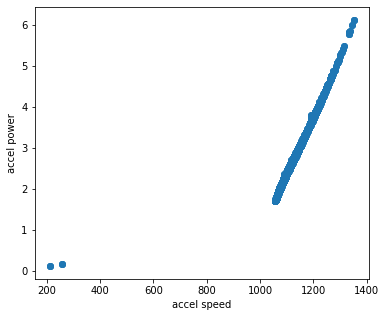

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5), squeeze=False)
ax[0,0].scatter(df_i['speed'].values, df_i['power'].values)
ax[0,0].set_xlabel('accel speed')
ax[0,0].set_ylabel('accel power')

#ax[0,1].plot(df_i.loc['04714B601096'].index, df_i['speed'].values, color='green')
#ax[0,1].plot(df_i.loc['04714B601096'].index, df_i['power'].values*100 + 400, color='orange')

#df_i[['As','Ap']].plot(figsize=(20,20))


In [27]:
# hack - do not store model in db2
old_model_store = db.model_store
db.model_store = FileModelStore()

# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsib = BayesRidgeRegressor(['speed'], ['power'])
et = spsib._build_entity_type(columns = [Column('speed',Float())], **jobsettings)
spsib._entity_type = et
df_i = spsib.execute(df=df_i)

db.model_store = old_model_store
df_i.describe()

2021-02-05T15:14:53.524 INFO iotfunctions.dbtables.__init__ Init FileModelStore
2021-02-05T15:14:53.525 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2021-02-05T15:14:53.526 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.3.1
2021-02-05T15:14:53.526 DEBUG iotfunctions.util.__init__ Starting trace
2021-02-05T15:14:53.527 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_BayesRidgeRegressor_20210205141453
2021-02-05T15:14:53.527 DEBUG iotfunctions.util.__init__ auto_save None
2021-02-05T15:14:53.528 DEBUG iotfunctions.util.categorize_args categorizing arguments
2021-02-05T15:14:53.529 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2021-02-05T15:14:53.529 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_BAYESRIDGERE

,rms_x,rms_z,rms_y,power,speed,predicted_rms_x,pred_dev_rms_x,predicted_rms_y,pred_dev_rms_y,predicted_rms_z,pred_dev_rms_z,predicted_power,stddev_power
count,177980.000000,177980.000000,177980.000000,177980.000000,177980.000000,177980.000000,177980.000000,177980.000000,177980.000000,177980.000000,177980.000000,177980.000000,1.779800e+05
mean,0.201499,0.087049,0.964827,2.052877,1079.609838,0.199317,0.243256,0.964607,0.024917,0.080121,0.096390,1079.609838,2.494303e-05
std,0.101279,0.028381,0.005473,0.435038,30.031477,0.050033,0.103079,0.004391,0.005371,0.002173,0.027322,30.031477,6.791502e-07
min,0.018446,0.027219,0.952113,0.115600,212.000000,0.051936,-0.043635,0.959193,0.007013,-0.304107,-0.205957,212.000000,6.093499e-06
25%,0.108721,0.065397,0.959472,1.740200,1059.000000,0.202365,0.173472,0.960191,0.020119,0.080134,0.075043,1059.000000,2.447661e-05
50%,0.189055,0.078209,0.965996,1.795200,1062.000000,0.205529,0.305867,0.963184,0.022496,0.080134,0.083694,1062.000000,2.454446e-05
75%,0.278364,0.100557,0.969530,2.325800,1096.000000,0.218051,0.306096,0.969012,0.030674,0.080134,0.112059,1096.000000,2.531369e-05
max,0.576303,0.244273,0.979979,6.122200,1353.000000,0.274805,1.510480,0.977185,0.134411,0.080134,0.160004,1353.000000,3.114243e-05


In [28]:
df_2 = df_i[0:10000]
df_2 = df_2[df_2['speed'] > 400]

2021-02-05T15:16:27.266 DEBUG matplotlib.font_manager._findfont_cached findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=bold:stretch=normal:size=12.0.
2021-02-05T15:16:27.266 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.335
2021-02-05T15:16:27.267 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.335
2021-02-05T15:16:27.267 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.335
2021-02-05T15:16:27.268 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.335
2021-02-05T15:16:27.268 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular norm

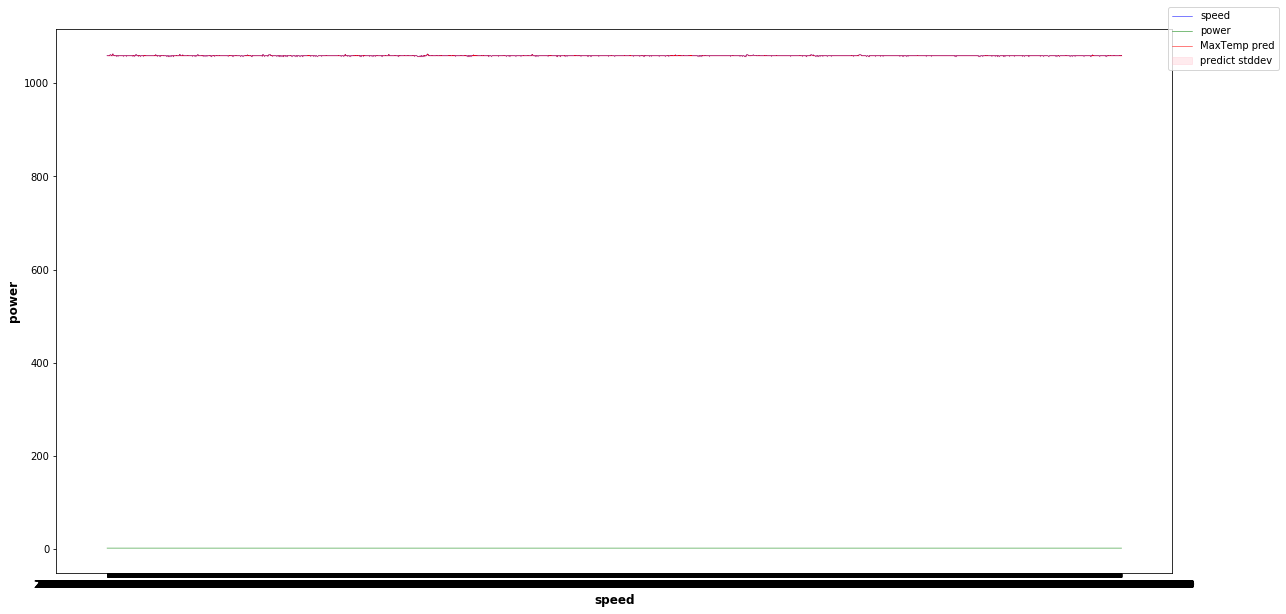

In [29]:
plots = 1

fig, ax = plt.subplots(plots, 1, figsize=(20,10), squeeze=False)
cnt = 0
ax[cnt,0].plot(df_2.unstack(level=0).index, df_2['speed'],linewidth=0.5,color='blue',label='speed')
ax[cnt,0].plot(df_2.unstack(level=0).index, df_2['power'],linewidth=0.5,color='green',label='power')
ax[cnt,0].plot(df_2.unstack(level=0).index, df_2['predicted_power'],linewidth=0.5,color='red',label='MaxTemp pred')
ax[cnt,0].fill_between(df_2.unstack(level=0).index, df_2['predicted_power'] - df_2['stddev_power'],
                df_2['predicted_power'] + df_2['stddev_power'], color="pink", alpha=0.3, label="predict stddev")
ax[cnt,0].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt,0].set_ylabel('power',fontsize=12,weight="bold")
ax[cnt,0].set_xlabel('speed',fontsize=12,weight="bold")
cnt = 1

In [12]:
def load_data_short(filename):
    # load data
    df_input = pd.read_csv(filename, parse_dates=['RCV_TIMESTAMP_UTC'], comment='#')
    #df_input = df_input.asfreq('H')
    df_input = df_input.sort_values(by='RCV_TIMESTAMP_UTC').\
                    rename(columns={'RCV_TIMESTAMP_UTC':'timestamp', 'DEVICEID': 'entity'}).\
                    drop(columns=['DEVICETYPE', 'FORMAT','UPDATED_UTC','LOGICALINTERFACE_ID','DEVICE_ID']).\
                    drop(columns=['RMS_X','RMS_Y','RMS_Z'])
    #df_input = df_input[df_input['VERSION'] != 0].drop(columns=['VERSION'])
       
    return df_input
    
def prep_data_short(df_input):
    entity = df_input['entity'].values[0]
    
    list_ac_vx = []
    cnt = 0
    for idx,row in df_input[['timestamp','VIBRATIONS_XAXIS','ACCEL_SPEED']].iterrows():
        if isinstance(row['timestamp'], str):
            ts = datetime.datetime.strptime(row['timestamp'], '%Y-%m-%d-%H.%M.%S.%f')
        else:
            ts = row['timestamp']
            
        rvibs = row['VIBRATIONS_XAXIS']
        racc = row['ACCEL_SPEED']
        
        if isinstance(racc, str):
            racc = eval(racc)

        if not isinstance(racc, list) and math.isnan(racc):
            continue
            
        if isinstance(rvibs, str):
            list_ac = []
           
            for ac in racc:
                #print(ac)
                list_ac.append(eval(ac))
                list_ac.append(eval(ac))
                list_ac.append(eval(ac))
                #print (list_ac)

            list_vx = []
            for vx in eval(rvibs):
                list_vx.append(vx)
                #print (list_vx)

            #print(list_ac, list_vx)
            cnt2 = 0
            for p in zip(list_ac, list_vx):
                #print(ts + datetime.timedelta(seconds = cnt2 * 10), p[0],p[1])
                list_ac_vx.append([ts + datetime.timedelta(seconds = cnt2 * 10), p[0],p[1]])
                cnt2 += 1
        cnt += 1

    df_clean = pd.DataFrame(list_ac_vx, columns=['timestamp','Ap','Vx'])
    df_clean['Ap'] = df_clean['Ap']/1000
    df_clean['entity'] = entity
    
    return df_clean.set_index(['entity','timestamp'])
    

In [13]:
#df_clean2 = prep_data(load_data('./IOT_PUMP_DE_GEN5_202012151526.csv'))
df_clean2 = prep_data_short(load_data_short('./04714B603408.csv'))
#df_clean2.describe()
df_clean2.head(2)
df_clean2.index.levels[0].values[0]

'04714B603408'

In [14]:
df_clean2.describe()

,Ap,Vx
count,1.371300e+06,1.371300e+06
mean,1.501744e+00,-2.946143e-02
std,1.482848e+00,1.308858e-01
min,0.000000e+00,-1.039100e+00
25%,0.000000e+00,-4.390000e-02
50%,1.281000e+00,-2.730000e-02
75%,3.099000e+00,-8.800000e-03
max,3.780000e+00,1.035200e+00


<Figure size 1152x432 with 0 Axes>

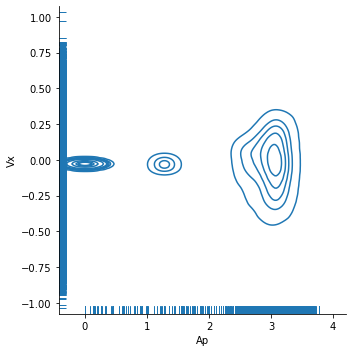

In [15]:

plt.figure(figsize=(16, 6))
g = sns.displot(df_clean2[['Ap','Vx']], x='Ap', y='Vx', kind="kde", rug=True)
    
g.set_titles('KDE for' + df_clean2.index.levels[0].values[0])

In [16]:
df_i2 = df_clean2.copy()


In [17]:
%%time
print('Train and evaluate model for ' + df_i2.index.levels[0].values[0])
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsi2 = VIAnomalyScore(['Ap'], ['Vx'])
et = spsi2._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
spsi2._entity_type = et
spsi2.epochs = 300   # 1500 takes ages
df_i2 = spsi.execute(df=df_i2)

EngineLogging.configure_console_logging(logging.INFO)
df_i2.describe()

Train and evaluate model for 04714B603408
2020-12-22T13:57:10.081 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2020-12-22T13:57:10.082 DEBUG mmfunctions.anomaly.__init__ init KDE Estimator
2020-12-22T13:57:10.083 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.2.1
2020-12-22T13:57:10.084 DEBUG iotfunctions.util.__init__ Starting trace
2020-12-22T13:57:10.084 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_VIAnomalyScore_20201222125710
2020-12-22T13:57:10.084 DEBUG iotfunctions.util.__init__ auto_save None
2020-12-22T13:57:10.085 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-12-22T13:57:10.085 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-12-22T13:57:10.085 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEnti

2020-12-22T14:09:25.001 DEBUG mmfunctions.anomaly.execute Epoch: 720, Loss: 0.5140376091003418
2020-12-22T14:09:35.230 DEBUG mmfunctions.anomaly.execute Epoch: 730, Loss: 0.5148692727088928
2020-12-22T14:09:45.743 DEBUG mmfunctions.anomaly.execute Epoch: 740, Loss: 0.513357400894165
2020-12-22T14:09:56.328 DEBUG mmfunctions.anomaly.execute Epoch: 750, Loss: 0.5140331387519836
2020-12-22T14:10:06.852 DEBUG mmfunctions.anomaly.execute Epoch: 760, Loss: 0.5143701434135437
2020-12-22T14:10:17.249 DEBUG mmfunctions.anomaly.execute Epoch: 770, Loss: 0.5141509175300598
2020-12-22T14:10:27.786 DEBUG mmfunctions.anomaly.execute Epoch: 780, Loss: 0.5143022537231445
2020-12-22T14:10:38.410 DEBUG mmfunctions.anomaly.execute Epoch: 790, Loss: 0.5142222046852112
2020-12-22T14:10:49.238 DEBUG mmfunctions.anomaly.execute Epoch: 800, Loss: 0.5146180987358093
2020-12-22T14:11:00.254 DEBUG mmfunctions.anomaly.execute Epoch: 810, Loss: 0.5139776468276978
2020-12-22T14:11:11.208 DEBUG mmfunctions.anomaly.e

<ipython-input-17-bb9e9a5bbb29>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  get_ipython().run_cell_magic('time', '', "print('Train and evaluate model for ' + df_i2.index.levels[0].values[0])\n# Now run the anomaly functions as if they were executed in a pipeline\nEngineLogging.configure_console_logging(logging.DEBUG)\njobsettings = { 'db': db, \n               '_db_schema': 'public', 'save_trace_to_file' : True}\n\nspsi2 = VIAnomalyScore(['Ap'], ['Vx'])\net = spsi2._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)\nspsi2._entity_type = et\nspsi2.epochs = 300   # 1500 takes ages\ndf_i2 = spsi.execute(df=df_i2)\n\nEngineLogging.configure_console_logging(logging.INFO)\ndf_i2.describe()\n")


CPU times: user 1h 59min 6s, sys: 30min 21s, total: 2h 29min 27s
Wall time: 26min 37s


,Ap,Vx,predicted_Vx,pred_dev_Vx
count,1.371300e+06,1.371300e+06,1.371300e+06,1.371300e+06
mean,1.501744e+00,-2.946143e-02,-2.734308e-02,4.044737e-01
std,1.482848e+00,1.308858e-01,1.372179e-03,2.715333e-01
min,0.000000e+00,-1.039100e+00,-3.356946e-02,1.361498e-01
25%,0.000000e+00,-4.390000e-02,-2.845207e-02,1.361498e-01
50%,1.281000e+00,-2.730000e-02,-2.845207e-02,2.858738e-01
75%,3.099000e+00,-8.800000e-03,-2.569535e-02,6.752676e-01
max,3.780000e+00,1.035200e+00,-1.292527e-03,8.986392e-01


2020-12-22T14:50:14.011 WARNING matplotlib.legend._parse_legend_args No handles with labels found to put in legend.


Text(0.5, 1.0, 'pump 04714B603408 - plain scatterplot')

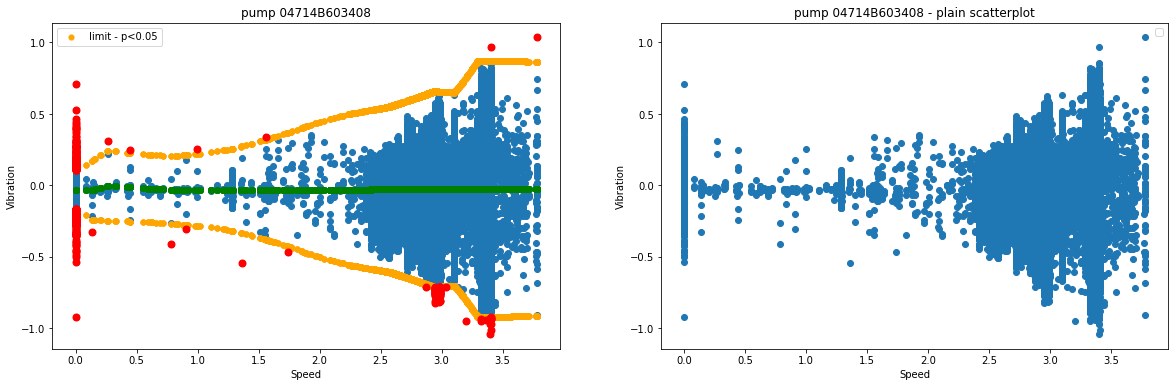

In [26]:
entity = df_i2.index.levels[0].values[0]

df_1 = df_i2.loc[entity].copy()


arr1 = np.where(df_1['Vx'] > df_1['predicted_Vx'] + df_1['pred_dev_Vx'], df_1['Vx'], 0) + \
       np.where(df_1['Vx'] < df_1['predicted_Vx'] - df_1['pred_dev_Vx'], df_1['Vx'], 0)
arr1[arr1 == 0] = np.nan
df_1['Anomaly'] = arr1

fig, ax = plt.subplots(1, 2, figsize=(20, 6), squeeze=False)

ax[0,0].scatter(df_1['Ap'], df_1['Vx'])
ax[0,0].scatter(df_1['Ap'], df_1['predicted_Vx'], color='green')
ax[0,0].scatter(df_1['Ap'], df_1['predicted_Vx'] - df_1['pred_dev_Vx'], color='orange', lw=0.1, label='limit - p<0.05')
ax[0,0].scatter(df_1['Ap'], df_1['predicted_Vx'] + df_1['pred_dev_Vx'], color='orange', lw=0.1)
ax[0,0].scatter(df_1['Ap'], df_1['Anomaly'], color='red', lw=2)
ax[0,0].set_xlabel('Speed')
ax[0,0].set_ylabel('Vibration')
ax[0,0].legend()
ax[0,0].set_title('pump ' + entity)

ax[0,1].scatter(df_i2['Ap'], df_i2['Vx'])
ax[0,1].set_xlabel('Speed')
ax[0,1].set_ylabel('Vibration')
ax[0,1].legend()
ax[0,1].set_title('pump ' + entity + ' - plain scatterplot')


In [27]:
df_1[df_1['Ap'] < 2.0]['Anomaly'] = np.nan
df_1[np.abs(df_1['Vx']) < 0.7]['Anomaly'] = np.nan

<ipython-input-27-11cbb9c58f70>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1[df_1['Ap'] < 2.0]['Anomaly'] = np.nan
<ipython-input-27-11cbb9c58f70>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1[np.abs(df_1['Vx']) < 0.7]['Anomaly'] = np.nan


Text(0.5, 1.0, 'pump 04714B603408')

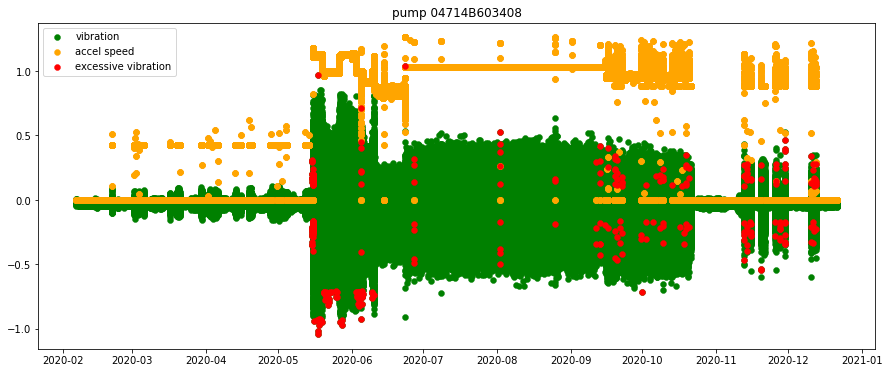

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6), squeeze=False)
#ax[0,0].plot(df_1['max'] + 2.0, lw=0.4, color='blue', label='smoothed max vib + 1')
ax[0,0].scatter(df_1.index,df_1['Vx'], lw=0.4, color='green', label='vibration')
ax[0,0].scatter(df_1.index,df_1['Ap']/3, lw=0.4, color='orange', zorder=5, label='accel speed')
ax[0,0].scatter(df_1.index, df_1['Anomaly'], lw=0.4, color='red', zorder=10, label='excessive vibration')
ax[0,0].legend()
ax[0,0].set_title('pump ' + df_i2.index.levels[0].values[0])

In [29]:
df_clean3 = prep_data_short(load_data_short('./04714B6036B1.csv'))
df_clean3.head(2)
df_clean3.index.levels[0].values[0]

'04714B6036B1'

<Figure size 1152x432 with 0 Axes>

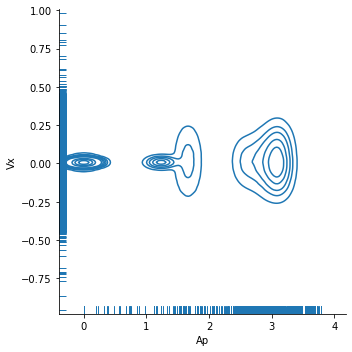

In [30]:
plt.figure(figsize=(16, 6))
g = sns.displot(df_clean3[['Ap','Vx']], x='Ap', y='Vx', kind="kde", rug=True)
    
g.set_titles('KDE for' + df_clean3.index.levels[0].values[0])

In [31]:
df_i3 = df_clean3.copy()

In [32]:
%%time
print('Train and evaluate model for ' + df_i3.index.levels[0].values[0])
# Now run the anomaly functions as if they were executed in a pipeline
EngineLogging.configure_console_logging(logging.DEBUG)
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

spsi3 = VIAnomalyScore(['Ap'], ['Vx'])
et = spsi3._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)
spsi3._entity_type = et
df_i3 = spsi.execute(df=df_i3)

EngineLogging.configure_console_logging(logging.INFO)
df_i3.describe()

Train and evaluate model for 04714B6036B1
2020-12-22T15:50:44.327 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2020-12-22T15:50:44.328 DEBUG mmfunctions.anomaly.__init__ init KDE Estimator
2020-12-22T15:50:44.328 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 8.2.1
2020-12-22T15:50:44.329 DEBUG iotfunctions.util.__init__ Starting trace
2020-12-22T15:50:44.330 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_VIAnomalyScore_20201222145044
2020-12-22T15:50:44.330 DEBUG iotfunctions.util.__init__ auto_save None
2020-12-22T15:50:44.331 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-12-22T15:50:44.331 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-12-22T15:50:44.332 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEnti

2020-12-22T16:08:27.718 DEBUG mmfunctions.anomaly.execute Epoch: 710, Loss: 0.4861690402030945
2020-12-22T16:08:48.223 DEBUG mmfunctions.anomaly.execute Epoch: 720, Loss: 0.4854114055633545
2020-12-22T16:09:10.729 DEBUG mmfunctions.anomaly.execute Epoch: 730, Loss: 0.48605582118034363
2020-12-22T16:09:31.181 DEBUG mmfunctions.anomaly.execute Epoch: 740, Loss: 0.48728975653648376
2020-12-22T16:09:41.966 DEBUG mmfunctions.anomaly.execute Epoch: 750, Loss: 0.4858241081237793
2020-12-22T16:09:52.462 DEBUG mmfunctions.anomaly.execute Epoch: 760, Loss: 0.4855801463127136
2020-12-22T16:10:02.648 DEBUG mmfunctions.anomaly.execute Epoch: 770, Loss: 0.48650646209716797
2020-12-22T16:10:13.460 DEBUG mmfunctions.anomaly.execute Epoch: 780, Loss: 0.4863134026527405
2020-12-22T16:10:24.221 DEBUG mmfunctions.anomaly.execute Epoch: 790, Loss: 0.48651033639907837
2020-12-22T16:10:34.580 DEBUG mmfunctions.anomaly.execute Epoch: 800, Loss: 0.48592084646224976
2020-12-22T16:10:45.270 DEBUG mmfunctions.ano

<ipython-input-32-c9f26aead716>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  get_ipython().run_cell_magic('time', '', "print('Train and evaluate model for ' + df_i3.index.levels[0].values[0])\n# Now run the anomaly functions as if they were executed in a pipeline\nEngineLogging.configure_console_logging(logging.DEBUG)\njobsettings = { 'db': db, \n               '_db_schema': 'public', 'save_trace_to_file' : True}\n\nspsi3 = VIAnomalyScore(['Ap'], ['Vx'])\net = spsi3._build_entity_type(columns = [Column('MinTemp',Float())], **jobsettings)\nspsi3._entity_type = et\ndf_i3 = spsi.execute(df=df_i3)\n\nEngineLogging.configure_console_logging(logging.INFO)\ndf_i3.describe()\n")


CPU times: user 2h 33min 9s, sys: 41min 20s, total: 3h 14min 30s
Wall time: 35min 1s


,Ap,Vx,predicted_Vx,pred_dev_Vx
count,1.368975e+06,1.368975e+06,1.368975e+06,1.368975e+06
mean,1.400429e+00,9.770501e-03,8.359868e-03,3.902670e-01
std,1.396439e+00,8.449316e-02,2.403382e-03,1.797408e-01
min,0.000000e+00,-9.580000e-01,6.013222e-03,2.128958e-01
25%,0.000000e+00,-1.370000e-02,6.013222e-03,2.128958e-01
50%,1.234000e+00,6.800000e-03,7.152006e-03,2.514825e-01
75%,3.099000e+00,2.930000e-02,1.133477e-02,5.796511e-01
max,3.780000e+00,9.834000e-01,1.609729e-02,6.654118e-01


2020-12-22T16:26:02.429 WARNING matplotlib.legend._parse_legend_args No handles with labels found to put in legend.


Text(0.5, 1.0, 'pump 04714B6036B1 - plain scatterplot')

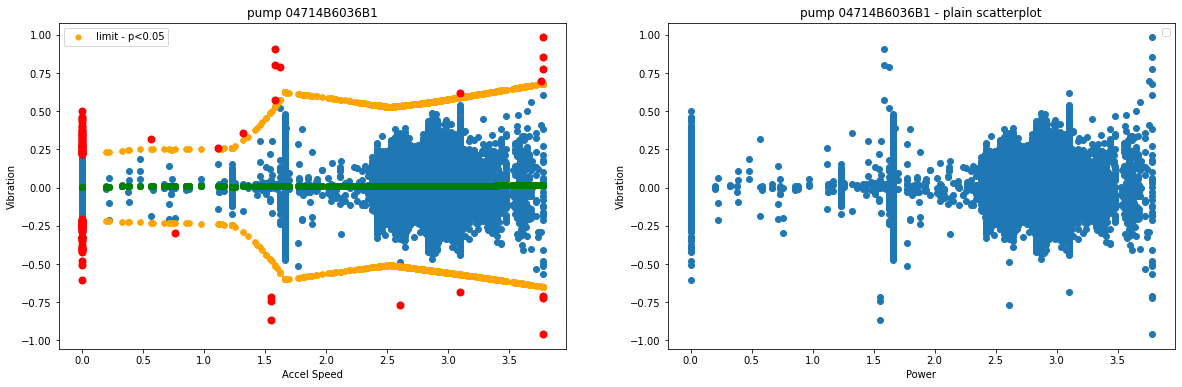

In [33]:
entity = df_i3.index.levels[0].values[0]

df_1 = df_i3.loc[entity].copy()


arr1 = np.where(df_1['Vx'] > df_1['predicted_Vx'] + df_1['pred_dev_Vx'], df_1['Vx'], 0) + \
       np.where(df_1['Vx'] < df_1['predicted_Vx'] - df_1['pred_dev_Vx'], df_1['Vx'], 0)
arr1[arr1 == 0] = np.nan
df_1['Anomaly'] = arr1

fig, ax = plt.subplots(1, 2, figsize=(20, 6), squeeze=False)

ax[0,0].scatter(df_1['Ap'], df_1['Vx'])
ax[0,0].scatter(df_1['Ap'], df_1['predicted_Vx'], color='green')
ax[0,0].scatter(df_1['Ap'], df_1['predicted_Vx'] - df_1['pred_dev_Vx'], color='orange', lw=0.1, label='limit - p<0.05')
ax[0,0].scatter(df_1['Ap'], df_1['predicted_Vx'] + df_1['pred_dev_Vx'], color='orange', lw=0.1)
ax[0,0].scatter(df_1['Ap'], df_1['Anomaly'], color='red', lw=2)
ax[0,0].set_xlabel('Accel Speed')
ax[0,0].set_ylabel('Vibration')
ax[0,0].legend()
ax[0,0].set_title('pump ' + entity)

ax[0,1].scatter(df_i3['Ap'], df_i3['Vx'])
ax[0,1].set_xlabel('Power')
ax[0,1].set_ylabel('Vibration')
ax[0,1].legend()
ax[0,1].set_title('pump ' + entity + ' - plain scatterplot')


In [34]:
df_1[df_1['Ap'] < 0.5]['Anomaly'] = np.nan
df_1[np.abs(df_1['Vx']) < 0.5]['Anomaly'] = np.nan

<ipython-input-34-dac41d32ec2f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1[df_1['Ap'] < 0.5]['Anomaly'] = np.nan
<ipython-input-34-dac41d32ec2f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1[np.abs(df_1['Vx']) < 0.5]['Anomaly'] = np.nan


Text(0.5, 1.0, 'pump 04714B6036B1')

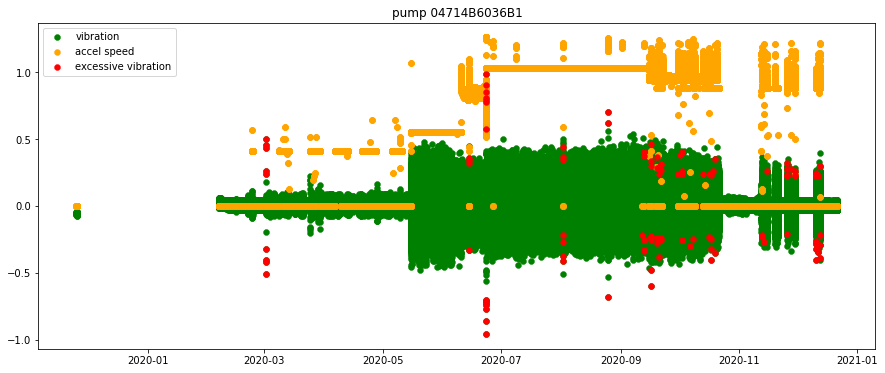

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6), squeeze=False)
#ax[0,0].plot(df_1['max'] + 2.0, lw=0.4, color='blue', label='smoothed max vib + 1')
ax[0,0].scatter(df_1.index,df_1['Vx'], lw=0.4, color='green', label='vibration')
ax[0,0].scatter(df_1.index,df_1['Ap']/3, lw=0.4, color='orange', zorder=5, label='accel speed')
ax[0,0].scatter(df_1.index, df_1['Anomaly'], lw=0.4, color='red', zorder=10, label='excessive vibration')
ax[0,0].legend()
ax[0,0].set_title('pump ' + df_i3.index.levels[0].values[0])

#### Approximate with Gaussian

major contribution: gaussian along x/y coordinates, start with diagonal covariance matrix:

likelihood:

$e^{\frac{ {(\mu_0 - x)}^2}{\sigma_0} \frac{ {(\mu_1 - y)}^2}{\sigma_1}  }$


ModuleNotFoundError: No module named 'tensorflow.contrib'

In [ ]:
# theta_0, theta_1 = mu_0/mu_1, theta_2/theta_3 = sigma_0/ sigma_1
def log_likelihood(theta, F, e):
    
    
    return np.sum(theta[0]
        
        np.log(2 * np.pi * (theta[1] ** 2 + theta[2] ** 2))
                         + (theta[0]) ** 2 / (theta[1] ** 2 + theta[2] ** 2))



def log_prior(theta):
    # sigma needs to be positive.
    if theta[1] <= 0:
        return -np.inf
    else:
        return 0

def log_posterior(theta, F, e):
    return log_prior(theta) + log_likelihood(theta, F, e)

# same setup as above:
ndim, nwalkers = 2, 50
nsteps, nburn = 2000, 1000

starting_guesses = np.random.rand(nwalkers, ndim)
starting_guesses[:, 0] *= 2000  # start mu between 0 and 2000
starting_guesses[:, 1] *= 20    # start sigma between 0 and 20

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[F, e])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, 2)